# Exploratory analysis

Here we take a look at the stanford-hatespeech dataset
and try to extract and visualize its main characteristics.

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from spacy.symbols import nsubj
from src.data.preprocess.helpers import (
    compare,
    contains_bigram,
    count_pejorative_bigrams,
    find_most_common_nouns,
    generate_ngrams,
    part_of_speech_frequency,
    verb_noun_syntactic_relation,
    syntactic_dependency_frequency,
    verb_noun_word_vectors,
)
from src.utils.misc import create_spacy_docs
from src.utils.preprocess_text_helpers import remove_stopwords
from src.visualization.visualize_exploratory_data_analysis import plot_word_vectors
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# fig_path="../../reports/hatespeech/figures/"

Let's load Spacy's language model (English-medium).
This will take a few seconds.

In [3]:
nlp = spacy.load("en_core_web_md")

The data is stored in CSV format, let's load it to a pandas dataframe:

In [4]:
data = pd.read_csv("../../data/external/hatespeech/clean_sexism_dataset.csv", index_col=0)

What does the data look like?

In [5]:
data.head()

,text,label
0,these two are revolting 2015,1
1,katieandnikki stop calling yourselves pretty a...,1
2,"if channel7 keep these girls in the comp, whic...",1
3,the menus look like they were made by a 5 year...,1
4,wish these blondes were in that how to get awa...,1


In [6]:
data.shape

(14906, 2)

What's the positive vs negative label distribution?

In [7]:
data['label'].mean()

0.2301086810680263

In [8]:
data['label'].sum()

3430

23% of the tweets are mysoginistic, which amounts to 3430 total tweets.
Let's look at a couple examples.

In [9]:
data[data['label']==1].iloc[41, 0]

'jus gonna say it...again....dumb bitch! '

In [10]:
data[data['label']==0].iloc[21, 0]

'i look at all these  meals and wonder how many stopped for a hamburger afterwards.'

Now we parse the text and create tokens along with their properties.
This may take half a minute.

In [12]:
%%time
docs = list(nlp.pipe(data['text']))

CPU times: user 29.7 s, sys: 856 ms, total: 30.5 s
Wall time: 30.5 s


In [13]:
docs[0]

these two are revolting  2015

In [14]:
docs[0][0].is_stop

True

In [15]:
docs[0].ents

(two, 2015)

In [16]:
list(docs[0])

[these, two, are, revolting,  , 2015]

In [17]:
def filter_punct_space_stop(doc):
    filtered = []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space:
            continue
        filtered.append(token.text)
    return filtered

In [18]:
%%time
tokens_no_stopwords = list(map(filter_punct_space_stop, docs))
tokens_no_stopwords[:2]

CPU times: user 281 ms, sys: 29 µs, total: 281 ms
Wall time: 280 ms


[['revolting', '2015'],
 ['katieandnikki',
  'stop',
  'calling',
  'pretty',
  'hot',
  "you're",
  'saying',
  'million',
  'times',
  'stfu']]

In [19]:
number_of_tokens = list(map(len, tokens_no_stopwords))
number_of_tokens[:5]

[2, 10, 7, 16, 4]

In [20]:
# data['tokens'] = list(map(lambda x: " ".join(x), tokens_no_stopwords))
data['tokens'] = tokens_no_stopwords

In [21]:
data.head()

,text,label,tokens
0,these two are revolting 2015,1,"[revolting, 2015]"
1,katieandnikki stop calling yourselves pretty a...,1,"[katieandnikki, stop, calling, pretty, hot, yo..."
2,"if channel7 keep these girls in the comp, whic...",1,"[channel7, girls, comp, suspect, watch, again...."
3,the menus look like they were made by a 5 year...,1,"[menus, look, like, 5, year, old, little, girl..."
4,wish these blondes were in that how to get awa...,1,"[wish, blondes, away, murder]"


### Top words

In [22]:
data_msgn = data[data['label']==1]
data_non_msgn = data[data['label']==0]

In [23]:
from collections import Counter

In [24]:
count_msgn = Counter()

In [25]:
for idx, toks in data_msgn['tokens'].iteritems():
    for token in toks:
        count_msgn[token] += 1

In [26]:
count_msgn.most_common(10)

[('sexist', 970),
 ('women', 530),
 ('kat', 359),
 ('girls', 294),
 ('like', 246),
 ('men', 210),
 ('notsexist', 207),
 ('female', 201),
 ('think', 171),
 ('woman', 168)]

In [27]:
count_non_msgn = Counter()

In [28]:
for idx, toks in data_non_msgn['tokens'].iteritems():
    for token in toks:
        count_non_msgn[token] += 1

In [29]:
count_non_msgn.most_common(10)

[('kat', 708),
 ('like', 639),
 ('amp', 513),
 ('people', 490),
 ('andre', 468),
 ('women', 342),
 ('think', 326),
 ('isis', 319),
 ('time', 305),
 ('know', 291)]

In [66]:
# Here order is important
labels = ("Misogyny", "No Misogyny")
counters = (count_msgn, count_non_msgn)
most_common = {}
for label, counter in zip(labels, counters):
    most_common[label] = {}
    most_common[label]['total_number_of_words'] = len(counter)
    most_common[label]['top_words'] = [w for (w, c) in counter.most_common(10)]
    most_common[label]['counts'] = [c for (w, c) in counter.most_common(10)]

In [67]:
most_common

{'Misogyny': {'total_number_of_words': 8550,
  'top_words': ['sexist',
   'women',
   'kat',
   'girls',
   'like',
   'men',
   'notsexist',
   'female',
   'think',
   'woman'],
  'counts': [970, 530, 359, 294, 246, 210, 207, 201, 171, 168]},
 'No Misogyny': {'total_number_of_words': 17090,
  'top_words': ['kat',
   'like',
   'amp',
   'people',
   'andre',
   'women',
   'think',
   'isis',
   'time',
   'know'],
  'counts': [708, 639, 513, 490, 468, 342, 326, 319, 305, 291]}}

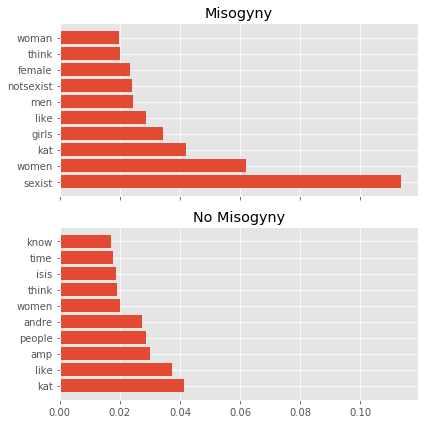

In [74]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
for label, ax in zip(labels, axes):
    ax.set_title(label)
    word_ratio = np.array(most_common[label]['counts']) / most_common[label]['total_number_of_words']
    ax.barh(most_common[label]['top_words'], word_ratio);
plt.tight_layout()

### Wordcloud

In [140]:
from wordcloud import WordCloud

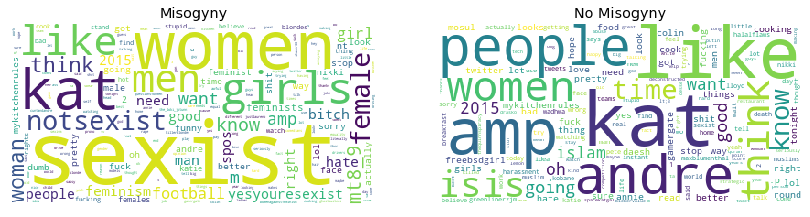

In [150]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 3))
for label, ax, frequencies in zip(labels, axes, counters):
    ax.set_title(label)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    wc = WordCloud(background_color='white').generate_from_frequencies(
        frequencies,
    )
    ax.imshow(wc)
plt.tight_layout()

### Tweets length

Here we compare the length of tweets measured as their total number of characters.
The histograms show a normalized density.

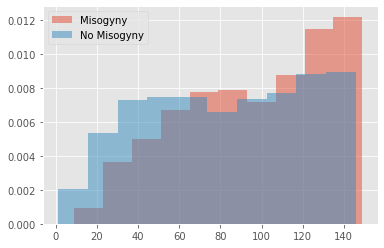

In [90]:
plt.hist(data_msgn['text'].apply(len), density=True, alpha=.5, label="Misogyny")
plt.hist(data_non_msgn['text'].apply(len), density=True, alpha=.5, label="No Misogyny")
plt.legend();

It looks like misogynistic tweets tend to use more characters.

In [121]:
[token for token in docs[0]]

[these, two, are, revolting,  , 2015]

In [119]:
[token.dep_ for token in docs[1]]

['nsubj',
 'ROOT',
 'xcomp',
 'dobj',
 'oprd',
 'cc',
 'conj',
 'punct',
 'nsubj',
 'case',
 'cc',
 'conj',
 'dobj',
 'quantmod',
 'nummod',
 'npadvmod',
 'aux',
 'neg',
 'ROOT',
 'dobj',
 'advmod',
 'punct',
 'ROOT']

In [108]:
t = [token for token in docs[0]][0]

In [109]:
t

these

In [110]:
list(t.ancestors)

[two, are]

In [113]:
t.dep_

'det'

## Old stuff below

In [44]:
%%time
# data['docs'] = create_spacy_docs(data, "text")
data['docs'] = docs

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 118 ms


In [45]:
%%time
misogynistic_docs = data.loc[data.loc[:,'label'] == 1, "docs"]
non_misogynistic_docs = data.loc[data.loc[:,'label'] == 0, "docs"]

CPU times: user 1.13 ms, sys: 7.91 ms, total: 9.04 ms
Wall time: 7.44 ms


In [46]:
%%time
number_of_words_in_misogynistic = sum([len(doc) for doc  in misogynistic_docs])
number_of_words_in_non_misogynistic = sum([len(doc) for doc  in non_misogynistic_docs])

CPU times: user 14.9 ms, sys: 3.83 ms, total: 18.8 ms
Wall time: 17.6 ms


In [47]:
data['docs'].iloc[0]

these two are revolting  2015

In [48]:
%%time
data['stopwords'] = data['text'].apply(remove_stopwords)
data['stopwords_docs'] = create_spacy_docs(data, "stopwords")

CPU times: user 2min 40s, sys: 209 ms, total: 2min 40s
Wall time: 2min 40s


In [49]:
%%time
stop_misogynistic_docs = data.loc[data.loc[:,'label'] == 1, "stopwords_docs"]
stop_non_misogynistic_docs = data.loc[data.loc[:,'label'] == 0, "stopwords_docs"]

number_of_words_in_misogynistic_stop = sum([len(doc) for doc  in stop_misogynistic_docs])
number_of_words_in_non_misogynistic_stop = sum([len(doc) for doc  in stop_non_misogynistic_docs])

misogynistic_common_nouns = pd.DataFrame(find_most_common_nouns(stop_misogynistic_docs), columns=['noun', 'count'])
non_misogynistic_common_nouns = pd.DataFrame(find_most_common_nouns(stop_non_misogynistic_docs), columns=['noun', 'count'])

misogynistic_common_nouns['count'] = misogynistic_common_nouns['count']/number_of_words_in_misogynistic_stop
non_misogynistic_common_nouns['count'] = non_misogynistic_common_nouns['count']/number_of_words_in_non_misogynistic_stop

CPU times: user 7.81 s, sys: 0 ns, total: 7.81 s
Wall time: 7.81 s


In [50]:
misogynistic_common_nouns

,noun,count
0,i,0.016001
1,women,0.004099
2,it,0.002192
3,kat,0.002060
4,girls,0.001819
...,...,...
6302,man circumstances,0.000022
6303,there.(well,0.000022
6304,walk,0.000022
6305,"false ""rape culture"" crisis amp",0.000022


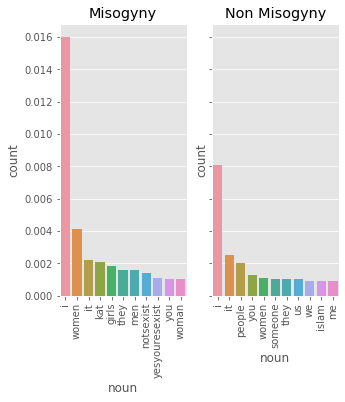

In [51]:
top_10_misogynistic = misogynistic_common_nouns.loc[0:10, :]
top_10_non_misogynistic = non_misogynistic_common_nouns.loc[0:10, :]

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(5,5))
misogynistic = sns.barplot(x=top_10_misogynistic['noun'], y=top_10_misogynistic['count'], ax=ax[0])
non_misogynistic = sns.barplot(x=top_10_non_misogynistic['noun'], y=top_10_non_misogynistic['count'], ax=ax[1])
ax[0].set_title("Misogyny")
ax[1].set_title("Non Misogyny")

def rotate_ticks(graph1, graph2):
    for item1, item2 in zip(graph1.get_xticklabels(), graph2.get_xticklabels()):
        item1.set_rotation(90)
        item2.set_rotation(90)

rotate_ticks(misogynistic,non_misogynistic)

# plt.savefig(fig_path+"top_10_common_nouns_total_corpus.png")
# plt.show()


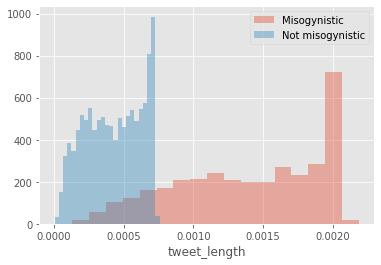

In [54]:
data['tweet_length'] = data["text"].apply(lambda tweet: len(tweet))
data.groupby('label').mean()['tweet_length']

sns.distplot(data.loc[data.loc[:,'label'] == 1, "tweet_length"]/number_of_words_in_misogynistic, kde=False, label="Misogynistic")
sns.distplot(data.loc[data.loc[:,'label'] == 0, "tweet_length"]/number_of_words_in_non_misogynistic, kde=False, label="Not misogynistic")

# plt.savefig(fig_path+"tweet_length_total_corpus.png")

plt.legend();

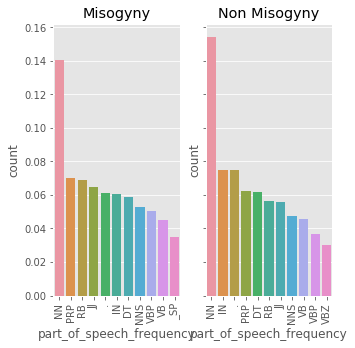

In [94]:
top_10_misogynistic_pos, top_10_non_misogynistic_pos = compare(part_of_speech_frequency, misogynistic_docs, non_misogynistic_docs)
top_10_misogynistic_pos['count'] = top_10_misogynistic_pos['count']/number_of_words_in_misogynistic
top_10_non_misogynistic_pos['count'] = top_10_non_misogynistic_pos['count']/number_of_words_in_non_misogynistic

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(5,5))
misogynistic = sns.barplot(x=top_10_misogynistic_pos[part_of_speech_frequency.__name__], y=top_10_misogynistic_pos['count'], ax=ax[0])
non_misogynistic = sns.barplot(x=top_10_non_misogynistic_pos[part_of_speech_frequency.__name__], y=top_10_non_misogynistic_pos['count'], ax=ax[1])

ax[0].set_title("Misogyny")
ax[1].set_title("Non Misogyny")

rotate_ticks(misogynistic, non_misogynistic)    
# plt.savefig(fig_path+"pos_frequency_total_corpus.png")
# plt.show()

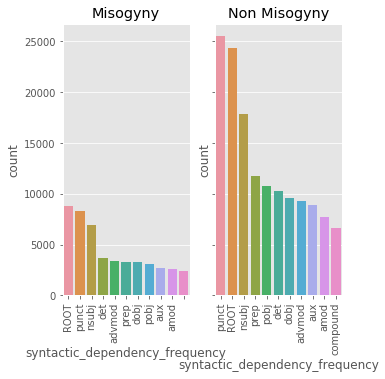

In [130]:
top_10_misogynistic_dep, top_10_non_misogynistic_dep = compare(syntactic_dependency_frequency, misogynistic_docs, non_misogynistic_docs)

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(5,5))
misogynistic = sns.barplot(x=top_10_misogynistic_dep[syntactic_dependency_frequency.__name__], y=top_10_misogynistic_dep['count'], ax=ax[0])
non_misogynistic = sns.barplot(x=top_10_non_misogynistic_dep[syntactic_dependency_frequency.__name__], y=top_10_non_misogynistic_dep['count'], ax=ax[1])

ax[0].set_title("Misogyny")
ax[1].set_title("Non Misogyny")

rotate_ticks(misogynistic, non_misogynistic)  
# plt.savefig(fig_path+"syntactic_frequency_total_corpus.png")   

# plt.show()

In [136]:
nsubj

429

In [131]:
nsubj_verbs = verb_noun_syntactic_relation(data['docs'], nsubj)  
df_nsubj = pd.DataFrame(nsubj_verbs, columns=["subject", "head_verb"])
print("Verbs Men")
set(df_nsubj[df_nsubj['subject'].str.contains(r"\b(man|men)\b")]['head_verb'].to_list())
print("Verbs Women")
set(df_nsubj[df_nsubj['subject'].str.contains(r"\b(woman|women)\b")]['head_verb'].to_list())

Verbs Men
Verbs Women


/home/guzzo/anaconda3/envs/find-out/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


{'s,
 need,
 speak,
 hide,
 care,
 being,
 been,
 give,
 needed,
 are,
 stay,
 understand,
 are,
 were,
 is,
 give,
 offer,
 are,
 have,
 break,
 was,
 know,
 is,
 rips,
 are,
 are,
 be,
 are,
 feel,
 are,
 write,
 driving,
 gets,
 rap,
 disagree,
 face,
 let,
 ruled,
 have,
 be,
 marries,
 make,
 have,
 be,
 being,
 had,
 do,
 being,
 drive,
 have,
 need,
 died,
 are,
 lack,
 are,
 have,
 said,
 fighting,
 have,
 shame,
 argue,
 joke,
 decide,
 do,
 are,
 have,
 talk,
 seem,
 have,
 tend,
 are,
 wants,
 have,
 paicipate,
 talk,
 have,
 drive,
 have,
 explains,
 call,
 wear,
 get,
 stay,
 take,
 cook,
 familiarise,
 know,
 is,
 having,
 are,
 have,
 living,
 suck,
 be,
 play,
 are,
 control,
 need,
 is,
 see,
 ran,
 do,
 want,
 presents,
 proposing,
 look,
 prefer,
 exist,
 make,
 belong,
 drive,
 talks,
 taking,
 have,
 help,
 are,
 be,
 knowing,
 are,
 are,
 being,
 play,
 driving,
 play,
 fall,
 internalized,
 paicipating,
 did,
 play,
 have,
 assaulted,
 fights,
 drive,
 stand,
 tr

In [122]:
df_nsubj

,subject,head_verb
0,rolling,leaving
1,i,know
2,i,see
3,hostages,were
4,'s,face
...,...,...
23599,you,'re
23600,you,be
23601,i,admit
23602,i,planned


In [127]:
nsubj_verbs, verbs, nouns = verb_noun_word_vectors(data['docs'], nsubj)

In [135]:
nsubj_verbs

{('rolling', leaving),
 ('i', know),
 ('i', see),
 ('hostages', were),
 ("'s", face),
 ('people', need),
 ('you', 're),
 ('who', going),
 ('what', is),
 ('it', 's),
 ('andre', got),
 ('you', 're),
 ('you', cooked),
 ('karma', comes),
 ('who', announces),
 ('mikeofcc', slashing),
 ('night', go),
 ('’m', going),
 ('happiness', oppresses),
 ('it', 's),
 ('i', made),
 ('i', did),
 ('you', are),
 ('i', see),
 ('kat', is),
 ('i', announcing),
 ('i', swear),
 ('you', serving),
 ('it', is),
 ('tribe', steps),
 ('implementation', get),
 ('they', are),
 ('woman', play),
 ('they', are),
 ('i', need),
 ('tip', is),
 ('it', happened),
 ('world', is),
 ('mother', hoped),
 ('they', scored),
 ('it', 's),
 ('.', done),
 ('i', adore),
 ('vivek', got),
 ('it', go),
 ('algebra', came),
 ('i', thought),
 ('it', explain),
 ('i', hope),
 ('they', lace),
 ('that', provides),
 ('we', took),
 ('they', play),
 ('i', have),
 ('it', 's),
 ('that', 's),
 ('i', was),
 ('palestinians', defend),
 ('they', existed),
 (

In [128]:
nouns

chararray([['two'],
           ["you're"],
           ['i'],
           ...,
           [''],
           ["'s"],
           ['']], dtype='<U50')

Text(0.5, 1.0, 'Female Verbs')

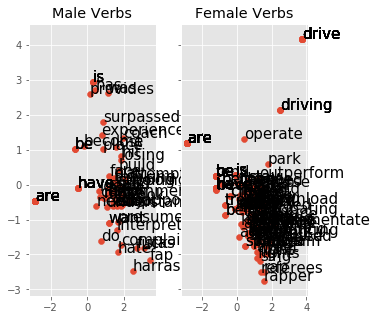

In [129]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(5,5))
male_verb_index = [n for n, j in enumerate(nouns) if j[0] == "man" or  j[0] == "men" ]
ax[0] = plot_word_vectors(nsubj_verbs[male_verb_index, :], verbs[male_verb_index, :], ax[0])
ax[0].set_title("Male Verbs")

female_verb_index = [n for n, j in enumerate(nouns) if j[0] == "woman" or  j[0] == "women" ]
ax[1] = plot_word_vectors(nsubj_verbs[female_verb_index, :], verbs[female_verb_index, :], ax[1])
ax[1].set_title("Female Verbs")
# plt.savefig(fig_path+"word_vectors_total_corpus.png")   

# plt.show()

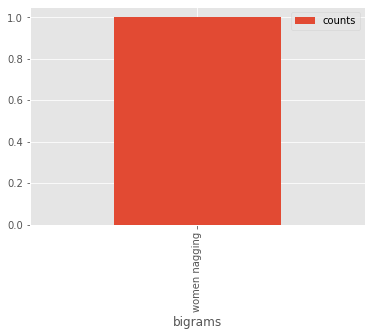

In [126]:
bigrams = data['text'].apply(lambda tweet: generate_ngrams(tweet, 2))
df_bigrams = pd.DataFrame(bigram for bigram in bigrams)
df_bigrams = df_bigrams.fillna("no bigram")

ADJECTIVE = ["battered", "untreated", "barren", "shrewish", "sheltered", "heartbroken", "unmarried", "undernourished", "underweight", "uncomplaining", "nagging"]
FEMALE = ["women", "woman"]

all_bigrams = []
for i in range(0, len(df_bigrams.columns)):
    all_bigrams.append(df_bigrams[i].apply(lambda bigram: contains_bigram(bigram, ADJECTIVE, FEMALE)))

counts = count_pejorative_bigrams(all_bigrams)
df_bigrams_counts = pd.DataFrame(counts, columns=["bigrams", "counts"]).groupby("bigrams").count().plot.bar()
# plt.show()